In [59]:
import numpy as np
import torch
from torch import nn
import tqdm

In [60]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [61]:
def get_data(train_batch_size, val_batch_size, test_batch_size):
  # Use the following code to load and normalize the dataset for training and testing
  # It will downlad the dataset into data subfolder (change to your data folder name)
  train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))

  test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))


  # Use the following code to create a validation set of 10%
  train_indices, val_indices, _, _ = train_test_split(
      range(len(train_dataset)),
      train_dataset.targets,
      stratify=train_dataset.targets,
      test_size=0.1,
  )

  # Generate training and validation subsets based on indices
  train_split = Subset(train_dataset, train_indices)
  val_split = Subset(train_dataset, val_indices)


  # Define dataloader objects that help to iterate over batches and samples for
  # training, validation and testing
  train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
  val_batches = DataLoader(val_split, batch_size=val_batch_size, shuffle=True)
  test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

  return train_batches, val_batches, test_batches


In [62]:
#Define your (As Cool As It Gets) Fully Connected Neural Network
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, neurons, drop_out_p, batch_norm):
        super(ACAIGFCN, self).__init__()
        #Define the network layer(s) and activation function(s)
        self.layers = nn.ModuleList([nn.Linear(input_dim, neurons[0])])
        for i in range(len(neurons)-1):
          if batch_norm:
            self.layers.extend([nn.BatchNorm1d(neurons[i])])
          self.layers.extend([torch.nn.Dropout(p=drop_out_p)])
          self.layers.extend([nn.Linear(neurons[i], neurons[i+1])])
        if batch_norm:
          self.layers.extend([nn.BatchNorm1d(neurons[-1])])
        self.layers.extend([torch.nn.Dropout(p=drop_out_p)])
        self.layers.extend([nn.Linear(neurons[-1], output_dim)])
        self.drop_out = nn.Dropout(p=drop_out_p)
    def forward(self, input):
        #Define how your model propagates the input through the network
        output = input
        for layer in self.layers[:-1]:
          output = nn.functional.relu(layer(output))
        output = self.layers[-1](output)
        return output

In [63]:
def init_weights_xavier(model):
    if type(model) == nn.Linear:
        torch.nn.init.xavier_normal_(model.weight)

In [64]:
def init_weights_random(model):
    if type(model) == nn.Linear:
        torch.nn.init.normal_(model.weight)

In [65]:
def init_weights_kaiming(model):
    if type(model) == nn.Linear:
        torch.nn.init.kaiming_uniform_(model.weight)

In [66]:
def calculate_test(model, test_batches):
    #Calculate accuracy on test set
    with torch.no_grad():
        test_acc = 0
        for test_features, test_labels in test_batches:
          test_features, test_labels = test_features.to(device), test_labels.to(device)
          model.eval()
          # Reshape test images into a vector
          test_features = test_features.reshape(-1, 28*28)

          # Compute validation outputs (targets)
          # and compute accuracy
          test_outputs = model(test_features)
          correct = (torch.argmax(test_outputs, dim=1) == test_labels).type(torch.FloatTensor)
          test_acc += correct.mean()
        # Compute total (mean) accuracy
        test_acc = test_acc/len(test_batches)
        # Report total (mean) accuracy, can also compute std based on batches
        print("Test Accuracy:" + str(test_acc.numpy()*100) + '%')

In [67]:
def epoch_plot(train_loss_list, validation_loss_list, validation_accuracy_list, optimizer_type):
  # Plot training loss and validation accuracy throughout the training epochs
  fig, ax = plt.subplots(1,2, figsize=(10,5))
  index = np.arange(1, len(train_loss_list)+1)
  ax[0].plot(index, train_loss_list, 'r-', label = 'Training Loss')
  ax[0].plot(index, validation_loss_list, 'b-', label = 'Validation loss')
  ax[0].legend()
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].title.set_text('Cross Entropy Loss (' + optimizer_type + ')')
  ax[1].plot(index, validation_accuracy_list, label = 'Validation acc')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Validation Accuracy')
  ax[1].title.set_text('Validation Accuracy')

Base Line Model:neuron_dim = [100,100], lr = 20, epochs = 30

In [68]:
def parameter_tunning(neuron_dim, epochs, train_batches, val_batches, test_batches, drop_out, weight_init, batch_norm, optimizer_type, lr):
  model = ACAIGFCN(input_dim = 784, output_dim = 10, neurons = neuron_dim, drop_out_p = drop_out, batch_norm=batch_norm)
  if optimizer_type == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
  elif optimizer_type == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  else:
    optimizer = torch.optim.RMSprop(model.parameters(), lr = lr)

  if weight_init == 'xavier':
    model.apply(init_weights_xavier)
  elif weight_init == 'random':
    model.apply(init_weights_random)
  elif weight_init == 'kaiming':
    model.apply(init_weights_kaiming)
  if torch.cuda.is_available():
    model.cuda()

  model_state = {'train_loss':1000, 'val_loss':1000, 'val_acc':0}
  train_loss_list = np.zeros((epochs,))
  validation_loss_list = np.zeros((epochs,))
  validation_accuracy_list = np.zeros((epochs,))
  loss_func = nn.CrossEntropyLoss()
  # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
  # Track the loss and validation accuracy
  for epoch in tqdm.trange(epochs):
      train_loss = np.zeros((len(train_batches),))
      val_loss = np.zeros((len(val_batches),))
      indexer = 0
      optimizer.zero_grad()
      # ACAIGFCN Training
      for train_features, train_labels in train_batches:
          train_features, train_labels = train_features.to(device), train_labels.to(device)
          # Set model into training mode
          model.train()

          # Reshape images into a vector
          train_features = train_features.reshape(-1, 28*28)

          # Reset gradients, Calculate training loss on model
          train_outputs = model(train_features)
          batch_loss_train = loss_func(train_outputs, train_labels)
          train_loss[indexer] = batch_loss_train.item()
          # Perfrom optimization, back propagation
          batch_loss_train.backward()
          optimizer.step()
          indexer += 1

      # Record loss for the epoch
      train_loss_list[epoch] = np.mean(train_loss)
      # ACAIGFCN Validation
      val_acc = 0
      indexer = 0
      for val_features, val_labels in val_batches:
          val_features, val_labels = val_features.to(device), val_labels.to(device)
          # Telling PyTorch we aren't passing inputs to network for training purpose
          with torch.no_grad():
              model.eval()

              # Reshape validation images into a vector
              val_features = val_features.reshape(-1, 28*28)

              # Compute validation outputs (targets)
              val_outputs = model(val_features)
              batch_loss_val = loss_func(val_outputs, val_labels)
              val_loss[indexer] = batch_loss_val.item()
              correct = (torch.argmax(val_outputs, dim=1) == val_labels).type(torch.FloatTensor)

              # and compute accuracy
              val_acc += correct.mean()
              indexer += 1
      # Record accuracy for the epoch; print training loss, validation accuracy
      val_mean_acc = val_acc/len(val_batches)
      validation_loss_list[epoch] = np.mean(val_loss)
      validation_accuracy_list[epoch] = val_mean_acc
      if train_loss_list[epoch] < model_state['train_loss']:
        model_state['train_loss'] = train_loss_list[epoch]
      if validation_loss_list[epoch] < model_state['val_loss']:
        model_state['val_loss'] = validation_loss_list[epoch]
        best_model = {'model_weights':model.state_dict(), 'optimizer_state':optimizer.state_dict()}
      if val_mean_acc > model_state['val_acc']:
        model_state['val_acc'] = val_mean_acc
      print("Epoch: "+ str(epoch))
      print("Validation Accuracy:" + str(validation_accuracy_list[epoch]*100) + '%')
      print('Training Loss:' + str(train_loss_list[epoch]))
      print('Validation Loss:' + str(validation_loss_list[epoch]))

  epoch_plot(train_loss_list, validation_loss_list, validation_accuracy_list, optimizer_type)
  model.load_state_dict(best_model['model_weights'])
  calculate_test(model, test_batches)
  return model_state

In [74]:
# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)
neuron_dim_base = [200, 200]
neuron_dim_optimal = [100, 100]
epochs = 30
lr_base = 0.005
lr_optimal= 0.0001
train_batches, val_batches, test_batches = get_data(train_batch_size, train_batch_size, test_batch_size)

# **Baseline Model Estabilishment**

  3%|▎         | 1/30 [00:10<05:04, 10.50s/it]

Epoch: 0
Validation Accuracy:65.14096260070801%
Training Loss:1.4501621458890304
Validation Loss:0.9123709350824356


  7%|▋         | 2/30 [00:21<04:57, 10.61s/it]

Epoch: 1
Validation Accuracy:81.3349187374115%
Training Loss:0.6328882192665676
Validation Loss:0.5280795867244402


 10%|█         | 3/30 [00:31<04:47, 10.65s/it]

Epoch: 2
Validation Accuracy:83.08494687080383%
Training Loss:0.4747428736596737
Validation Loss:0.4756651545564334


 13%|█▎        | 4/30 [00:42<04:37, 10.66s/it]

Epoch: 3
Validation Accuracy:84.128737449646%
Training Loss:0.4224953257812644
Validation Loss:0.4357902506987254


 17%|█▋        | 5/30 [00:53<04:27, 10.70s/it]

Epoch: 4
Validation Accuracy:85.44356226921082%
Training Loss:0.39107017331528215
Validation Loss:0.397830531001091


 20%|██        | 6/30 [01:03<04:15, 10.66s/it]

Epoch: 5
Validation Accuracy:85.44073104858398%
Training Loss:0.37409558414288285
Validation Loss:0.39717159420251846


 23%|██▎       | 7/30 [01:15<04:09, 10.84s/it]

Epoch: 6
Validation Accuracy:85.4598343372345%
Training Loss:0.3577617718926016
Validation Loss:0.3931379367907842


 27%|██▋       | 8/30 [01:26<03:59, 10.88s/it]

Epoch: 7
Validation Accuracy:85.84408760070801%
Training Loss:0.3505277583059275
Validation Loss:0.397891807059447


 30%|███       | 9/30 [01:36<03:47, 10.85s/it]

Epoch: 8
Validation Accuracy:84.52289700508118%
Training Loss:0.35071834907779154
Validation Loss:0.42460570981105167


 33%|███▎      | 10/30 [01:47<03:37, 10.88s/it]

Epoch: 9
Validation Accuracy:85.50937175750732%
Training Loss:0.3506172409035125
Validation Loss:0.4080811068415642


 37%|███▋      | 11/30 [01:58<03:27, 10.93s/it]

Epoch: 10
Validation Accuracy:85.91839671134949%
Training Loss:0.34086163524749147
Validation Loss:0.39171429723501205


 40%|████      | 12/30 [02:09<03:15, 10.88s/it]

Epoch: 11
Validation Accuracy:86.22763752937317%
Training Loss:0.32308896448252333
Validation Loss:0.3794016366203626


 43%|████▎     | 13/30 [02:20<03:06, 10.95s/it]

Epoch: 12
Validation Accuracy:87.57289052009583%
Training Loss:0.3113594465660599
Validation Loss:0.348321537176768


 47%|████▋     | 14/30 [02:31<02:54, 10.92s/it]

Epoch: 13
Validation Accuracy:85.79172492027283%
Training Loss:0.29899514761735807
Validation Loss:0.3744513690471649


 50%|█████     | 15/30 [02:42<02:42, 10.85s/it]

Epoch: 14
Validation Accuracy:86.68761253356934%
Training Loss:0.3013064760082173
Validation Loss:0.3664404625693957


 53%|█████▎    | 16/30 [02:52<02:31, 10.81s/it]

Epoch: 15
Validation Accuracy:87.34360337257385%
Training Loss:0.2998947647382628
Validation Loss:0.3511882747213046


 57%|█████▋    | 17/30 [03:04<02:21, 10.88s/it]

Epoch: 16
Validation Accuracy:86.58642172813416%
Training Loss:0.28627752105020127
Validation Loss:0.35495781401793164


 60%|██████    | 18/30 [03:14<02:10, 10.88s/it]

Epoch: 17
Validation Accuracy:86.83692812919617%
Training Loss:0.29335189146815605
Validation Loss:0.37205759435892105


 63%|██████▎   | 19/30 [03:26<02:00, 10.95s/it]

Epoch: 18
Validation Accuracy:87.66558766365051%
Training Loss:0.28595483781031844
Validation Loss:0.33833475410938263


 67%|██████▋   | 20/30 [03:36<01:48, 10.82s/it]

Epoch: 19
Validation Accuracy:87.2919499874115%
Training Loss:0.2723201084530579
Validation Loss:0.3451446940501531


 70%|███████   | 21/30 [03:46<01:36, 10.71s/it]

Epoch: 20
Validation Accuracy:87.06479072570801%
Training Loss:0.2666148085076854
Validation Loss:0.3544515296816826


 73%|███████▎  | 22/30 [03:58<01:26, 10.83s/it]

Epoch: 21
Validation Accuracy:87.30115294456482%
Training Loss:0.26734010889282767
Validation Loss:0.3398200360437234


 77%|███████▋  | 23/30 [04:08<01:15, 10.80s/it]

Epoch: 22
Validation Accuracy:88.12627792358398%
Training Loss:0.265921802453275
Validation Loss:0.3260693276921908


 80%|████████  | 24/30 [04:19<01:04, 10.74s/it]

Epoch: 23
Validation Accuracy:87.43560314178467%
Training Loss:0.2552675905655015
Validation Loss:0.3355959455172221


 83%|████████▎ | 25/30 [04:30<00:54, 10.87s/it]

Epoch: 24
Validation Accuracy:87.0223343372345%
Training Loss:0.2594294221896046
Validation Loss:0.3651655043164889


 87%|████████▋ | 26/30 [04:41<00:43, 10.77s/it]

Epoch: 25
Validation Accuracy:87.31105327606201%
Training Loss:0.2571089114501791
Validation Loss:0.34827497353156406


 90%|█████████ | 27/30 [04:51<00:32, 10.74s/it]

Epoch: 26
Validation Accuracy:87.31813430786133%
Training Loss:0.2570108141539232
Validation Loss:0.3471795643369357


 93%|█████████▎| 28/30 [05:02<00:21, 10.65s/it]

Epoch: 27
Validation Accuracy:87.45541572570801%
Training Loss:0.25651775328618176
Validation Loss:0.3440745572249095


 97%|█████████▋| 29/30 [05:12<00:10, 10.67s/it]

Epoch: 28
Validation Accuracy:86.374831199646%
Training Loss:0.25130659735427713
Validation Loss:0.3875121846795082


100%|██████████| 30/30 [05:23<00:00, 10.78s/it]

Epoch: 29
Validation Accuracy:87.062668800354%
Training Loss:0.26248095100218394
Validation Loss:0.365465780099233


Test Accuracy:86.0644519329071%


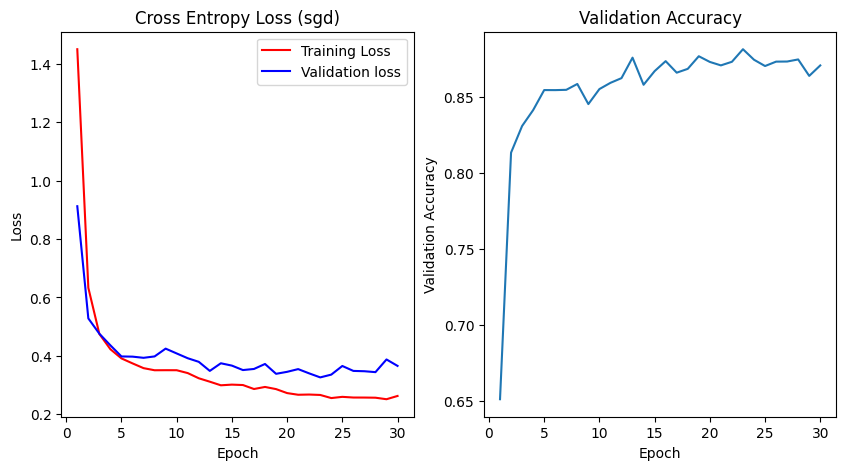

In [70]:
saved_states_base = parameter_tunning(neuron_dim_base, epochs, train_batches, val_batches, test_batches, 0, 'None', False, 'sgd', lr_base)

# **Optimizer Comparison**

  3%|▎         | 1/30 [00:10<05:12, 10.76s/it]

Epoch: 0
Validation Accuracy:65.6844437122345%
Training Loss:1.5310960856248748
Validation Loss:1.0131397445996602


  7%|▋         | 2/30 [00:21<04:57, 10.61s/it]

Epoch: 1
Validation Accuracy:77.47113108634949%
Training Loss:0.791597103735186
Validation Loss:0.6622596184412638


 10%|█         | 3/30 [00:32<04:48, 10.70s/it]

Epoch: 2
Validation Accuracy:80.24159073829651%
Training Loss:0.5730430309502583
Validation Loss:0.5641103908419609


 13%|█▎        | 4/30 [00:42<04:37, 10.69s/it]

Epoch: 3
Validation Accuracy:82.08503127098083%
Training Loss:0.5156200758691104
Validation Loss:0.5220472812652588


 17%|█▋        | 5/30 [00:53<04:27, 10.70s/it]

Epoch: 4
Validation Accuracy:83.34181904792786%
Training Loss:0.4721401297258881
Validation Loss:0.4696512718995412


 20%|██        | 6/30 [01:04<04:17, 10.74s/it]

Epoch: 5
Validation Accuracy:83.68999361991882%
Training Loss:0.4452296773780067
Validation Loss:0.47584811598062515


 23%|██▎       | 7/30 [01:14<04:06, 10.72s/it]

Epoch: 6
Validation Accuracy:84.81020927429199%
Training Loss:0.42495014532557074
Validation Loss:0.43796970943609875


 27%|██▋       | 8/30 [01:26<03:59, 10.88s/it]

Epoch: 7
Validation Accuracy:84.91494059562683%
Training Loss:0.41254031348903225
Validation Loss:0.43204469233751297


 30%|███       | 9/30 [01:37<03:51, 11.03s/it]

Epoch: 8
Validation Accuracy:84.89158749580383%
Training Loss:0.398269422211737
Validation Loss:0.4332699750860532


 33%|███▎      | 10/30 [01:48<03:39, 10.96s/it]

Epoch: 9
Validation Accuracy:84.4620406627655%
Training Loss:0.3889439980376442
Validation Loss:0.4309389293193817


 37%|███▋      | 11/30 [01:59<03:27, 10.90s/it]

Epoch: 10
Validation Accuracy:85.04090309143066%
Training Loss:0.38664517650064434
Validation Loss:0.435453861951828


 40%|████      | 12/30 [02:09<03:16, 10.89s/it]

Epoch: 11
Validation Accuracy:85.41949391365051%
Training Loss:0.38078598115804063
Validation Loss:0.40819120903809863


 43%|████▎     | 13/30 [02:21<03:05, 10.93s/it]

Epoch: 12
Validation Accuracy:85.15200614929199%
Training Loss:0.37079049393815816
Validation Loss:0.4135221590598424


 47%|████▋     | 14/30 [02:31<02:53, 10.86s/it]

Epoch: 13
Validation Accuracy:85.79667210578918%
Training Loss:0.36098693339329846
Validation Loss:0.3952595591545105


 50%|█████     | 15/30 [02:42<02:43, 10.92s/it]

Epoch: 14
Validation Accuracy:86.35430932044983%
Training Loss:0.35633978444450304
Validation Loss:0.39841147512197495


 53%|█████▎    | 16/30 [02:53<02:32, 10.88s/it]

Epoch: 15
Validation Accuracy:86.279296875%
Training Loss:0.348331333612496
Validation Loss:0.3875247885783513


 57%|█████▋    | 17/30 [03:04<02:21, 10.91s/it]

Epoch: 16
Validation Accuracy:86.75413131713867%
Training Loss:0.3357985199622388
Validation Loss:0.37192270408074063


 60%|██████    | 18/30 [03:14<02:09, 10.77s/it]

Epoch: 17
Validation Accuracy:86.4639937877655%
Training Loss:0.32824805884991054
Validation Loss:0.37353652715682983


 63%|██████▎   | 19/30 [03:25<01:58, 10.75s/it]

Epoch: 18
Validation Accuracy:86.62038445472717%
Training Loss:0.3252337726781953
Validation Loss:0.37307673195997876


 67%|██████▋   | 20/30 [03:36<01:47, 10.77s/it]

Epoch: 19
Validation Accuracy:86.65081858634949%
Training Loss:0.3235821895441919
Validation Loss:0.37322105715672177


 70%|███████   | 21/30 [03:47<01:37, 10.80s/it]

Epoch: 20
Validation Accuracy:86.89354062080383%
Training Loss:0.3207159509074013
Validation Loss:0.35891324033339816


 73%|███████▎  | 22/30 [03:57<01:25, 10.71s/it]

Epoch: 21
Validation Accuracy:87.03719973564148%
Training Loss:0.31140013165631386
Validation Loss:0.36705395579338074


 77%|███████▋  | 23/30 [04:08<01:15, 10.81s/it]

Epoch: 22
Validation Accuracy:87.16315627098083%
Training Loss:0.3045626187099601
Validation Loss:0.35135195900996524


 80%|████████  | 24/30 [04:20<01:05, 10.95s/it]

Epoch: 23
Validation Accuracy:87.52972483634949%
Training Loss:0.3021792585276208
Validation Loss:0.35878169536590576


 83%|████████▎ | 25/30 [04:31<00:55, 11.12s/it]

Epoch: 24
Validation Accuracy:87.49434351921082%
Training Loss:0.30267603104969243
Validation Loss:0.35211092233657837


 87%|████████▋ | 26/30 [04:42<00:43, 10.93s/it]

Epoch: 25
Validation Accuracy:87.47523427009583%
Training Loss:0.2933525284225086
Validation Loss:0.35356275488932926


 90%|█████████ | 27/30 [04:52<00:32, 10.87s/it]

Epoch: 26
Validation Accuracy:87.84887194633484%
Training Loss:0.2907477535729138
Validation Loss:0.3430839752157529


 93%|█████████▎| 28/30 [05:03<00:21, 10.91s/it]

Epoch: 27
Validation Accuracy:87.91680932044983%
Training Loss:0.2845317804307308
Validation Loss:0.3416673094034195


 97%|█████████▋| 29/30 [05:14<00:10, 10.88s/it]

Epoch: 28
Validation Accuracy:87.45965957641602%
Training Loss:0.2826092359873484
Validation Loss:0.3422341359158357


100%|██████████| 30/30 [05:25<00:00, 10.86s/it]

Epoch: 29
Validation Accuracy:88.16024661064148%
Training Loss:0.28386054258301574
Validation Loss:0.3370945726831754


Test Accuracy:87.4804675579071%


  3%|▎         | 1/30 [00:11<05:27, 11.29s/it]

Epoch: 0
Validation Accuracy:54.304659366607666%
Training Loss:2.230045840425311
Validation Loss:1.3041243851184845


  7%|▋         | 2/30 [00:22<05:11, 11.14s/it]

Epoch: 1
Validation Accuracy:48.195481300354004%
Training Loss:1.3695964891955537
Validation Loss:2.686496635278066


 10%|█         | 3/30 [00:32<04:54, 10.89s/it]

Epoch: 2
Validation Accuracy:45.515596866607666%
Training Loss:1.744346431966098
Validation Loss:2.4302135904630027


 13%|█▎        | 4/30 [00:43<04:40, 10.80s/it]

Epoch: 3
Validation Accuracy:58.961021900177%
Training Loss:1.8287530743850853
Validation Loss:1.2491440375645955


 17%|█▋        | 5/30 [00:54<04:31, 10.87s/it]

Epoch: 4
Validation Accuracy:55.932968854904175%
Training Loss:1.6114915592490502
Validation Loss:1.4279466768105824


 20%|██        | 6/30 [01:05<04:19, 10.80s/it]

Epoch: 5
Validation Accuracy:41.066575050354004%
Training Loss:1.5144388012166292
Validation Loss:1.5498850345611572


 23%|██▎       | 7/30 [01:16<04:09, 10.85s/it]

Epoch: 6
Validation Accuracy:61.12998127937317%
Training Loss:1.28356955748684
Validation Loss:1.366860955953598


 27%|██▋       | 8/30 [01:26<03:57, 10.81s/it]

Epoch: 7
Validation Accuracy:61.74069046974182%
Training Loss:1.2143674161074296
Validation Loss:1.0494583994150162


 30%|███       | 9/30 [01:37<03:47, 10.82s/it]

Epoch: 8
Validation Accuracy:72.29747176170349%
Training Loss:0.9536363825483142
Validation Loss:0.8909257054328918


 33%|███▎      | 10/30 [01:48<03:38, 10.94s/it]

Epoch: 9
Validation Accuracy:69.58432197570801%
Training Loss:0.9183621502147531
Validation Loss:0.9985354294379553


 37%|███▋      | 11/30 [01:59<03:25, 10.83s/it]

Epoch: 10
Validation Accuracy:70.12709975242615%
Training Loss:0.8261656187615305
Validation Loss:0.8778168459733328


 40%|████      | 12/30 [02:10<03:14, 10.83s/it]

Epoch: 11
Validation Accuracy:73.50967526435852%
Training Loss:0.7839548644029869
Validation Loss:0.7954860577980677


 43%|████▎     | 13/30 [02:21<03:05, 10.92s/it]

Epoch: 12
Validation Accuracy:71.27278447151184%
Training Loss:0.7684697300758002
Validation Loss:0.7606034030516943


 47%|████▋     | 14/30 [02:32<02:55, 10.95s/it]

Epoch: 13
Validation Accuracy:69.78671550750732%
Training Loss:0.6988300714852675
Validation Loss:0.7877625127633413


 50%|█████     | 15/30 [02:43<02:43, 10.92s/it]

Epoch: 14
Validation Accuracy:65.78776240348816%
Training Loss:0.8273631390535606
Validation Loss:0.9193097104628881


 53%|█████▎    | 16/30 [02:54<02:33, 10.97s/it]

Epoch: 15
Validation Accuracy:69.25384998321533%
Training Loss:0.8611003233576721
Validation Loss:1.043180411060651


 57%|█████▋    | 17/30 [03:06<02:24, 11.15s/it]

Epoch: 16
Validation Accuracy:65.90593457221985%
Training Loss:0.8661992904150261
Validation Loss:0.944765567779541


 60%|██████    | 18/30 [03:17<02:15, 11.32s/it]

Epoch: 17
Validation Accuracy:70.45757174491882%
Training Loss:0.9685310367143379
Validation Loss:1.1027755985657375


 63%|██████▎   | 19/30 [03:28<02:02, 11.11s/it]

Epoch: 18
Validation Accuracy:50.261831283569336%
Training Loss:1.0907364943117466
Validation Loss:1.56609841187795


 67%|██████▋   | 20/30 [03:39<01:50, 11.05s/it]

Epoch: 19
Validation Accuracy:57.69432187080383%
Training Loss:1.2654899426226347
Validation Loss:1.2202043533325195


 70%|███████   | 21/30 [03:50<01:39, 11.02s/it]

Epoch: 20
Validation Accuracy:58.32979679107666%
Training Loss:1.2361684930774401
Validation Loss:1.4350996911525726


 73%|███████▎  | 22/30 [04:01<01:28, 11.05s/it]

Epoch: 21
Validation Accuracy:58.68503451347351%
Training Loss:1.1662541937153295
Validation Loss:1.199143519004186


 77%|███████▋  | 23/30 [04:12<01:17, 11.09s/it]

Epoch: 22
Validation Accuracy:62.02162504196167%
Training Loss:1.2117112830000103
Validation Loss:1.1884170571962993


 80%|████████  | 24/30 [04:23<01:05, 10.94s/it]

Epoch: 23
Validation Accuracy:65.41836857795715%
Training Loss:1.109667959078303
Validation Loss:0.9593829115231832


 83%|████████▎ | 25/30 [04:34<00:55, 11.08s/it]

Epoch: 24
Validation Accuracy:66.23358130455017%
Training Loss:0.9487918058656296
Validation Loss:1.0113632877667744


 87%|████████▋ | 26/30 [04:45<00:44, 11.03s/it]

Epoch: 25
Validation Accuracy:65.90027809143066%
Training Loss:0.92854173172195
Validation Loss:1.0022258063157399


 90%|█████████ | 27/30 [04:56<00:32, 10.92s/it]

Epoch: 26
Validation Accuracy:66.22721552848816%
Training Loss:1.0185089218166639
Validation Loss:1.0332306275765102


 93%|█████████▎| 28/30 [05:06<00:21, 10.84s/it]

Epoch: 27
Validation Accuracy:66.285240650177%
Training Loss:0.8495329196723003
Validation Loss:1.1583845416704814


 97%|█████████▋| 29/30 [05:18<00:10, 10.98s/it]

Epoch: 28
Validation Accuracy:63.16731572151184%
Training Loss:1.100708840028295
Validation Loss:1.0855119824409485


100%|██████████| 30/30 [05:29<00:00, 10.97s/it]

Epoch: 29
Validation Accuracy:67.84136891365051%
Training Loss:1.0494627513975467
Validation Loss:1.0441379398107529


Test Accuracy:67.32422113418579%


  3%|▎         | 1/30 [00:11<05:33, 11.50s/it]

Epoch: 0
Validation Accuracy:82.6023280620575%
Training Loss:0.7750284660537288
Validation Loss:0.4866553023457527


  7%|▋         | 2/30 [00:22<05:10, 11.11s/it]

Epoch: 1
Validation Accuracy:83.107590675354%
Training Loss:0.46091187843736614
Validation Loss:0.4770137270291646


 10%|█         | 3/30 [00:33<05:04, 11.27s/it]

Epoch: 2
Validation Accuracy:84.75217819213867%
Training Loss:0.4119589036365725
Validation Loss:0.4438158298532168


 13%|█▎        | 4/30 [00:44<04:49, 11.12s/it]

Epoch: 3
Validation Accuracy:83.91573429107666%
Training Loss:0.3991382732143942
Validation Loss:0.4533868183692296


 17%|█▋        | 5/30 [00:55<04:37, 11.11s/it]

Epoch: 4
Validation Accuracy:84.43231582641602%
Training Loss:0.3936160442964086
Validation Loss:0.45192500948905945


 20%|██        | 6/30 [01:06<04:24, 11.00s/it]

Epoch: 5
Validation Accuracy:85.18809676170349%
Training Loss:0.3689200535135449
Validation Loss:0.4207263762752215


 23%|██▎       | 7/30 [01:17<04:12, 10.98s/it]

Epoch: 6
Validation Accuracy:85.74360013008118%
Training Loss:0.3559208931225651
Validation Loss:0.4209643279512723


 27%|██▋       | 8/30 [01:28<04:03, 11.07s/it]

Epoch: 7
Validation Accuracy:85.91201901435852%
Training Loss:0.35214581326493677
Validation Loss:0.40705348054567975


 30%|███       | 9/30 [01:39<03:53, 11.11s/it]

Epoch: 8
Validation Accuracy:85.593581199646%
Training Loss:0.3374004650790736
Validation Loss:0.4182098259528478


 33%|███▎      | 10/30 [01:51<03:41, 11.09s/it]

Epoch: 9
Validation Accuracy:85.49945950508118%
Training Loss:0.33048757207843493
Validation Loss:0.4506035844484965


 37%|███▋      | 11/30 [02:02<03:31, 11.15s/it]

Epoch: 10
Validation Accuracy:85.70751547813416%
Training Loss:0.3384332534558368
Validation Loss:0.4230331579844157


 40%|████      | 12/30 [02:13<03:21, 11.21s/it]

Epoch: 11
Validation Accuracy:85.82144379615784%
Training Loss:0.3369580411686088
Validation Loss:0.40934014320373535


 43%|████▎     | 13/30 [02:24<03:08, 11.11s/it]

Epoch: 12
Validation Accuracy:85.64524054527283%
Training Loss:0.3276400141558557
Validation Loss:0.4333769604563713


 47%|████▋     | 14/30 [02:35<02:57, 11.08s/it]

Epoch: 13
Validation Accuracy:86.1689031124115%
Training Loss:0.3341863855438412
Validation Loss:0.41806481530268985


 50%|█████     | 15/30 [02:46<02:46, 11.13s/it]

Epoch: 14
Validation Accuracy:86.9268000125885%
Training Loss:0.3159179791526974
Validation Loss:0.448995182911555


 53%|█████▎    | 16/30 [02:57<02:35, 11.11s/it]

Epoch: 15
Validation Accuracy:86.30972504615784%
Training Loss:0.3074331823384987
Validation Loss:0.39171580721934635


 57%|█████▋    | 17/30 [03:08<02:23, 11.03s/it]

Epoch: 16
Validation Accuracy:86.30194067955017%
Training Loss:0.29744841116216947
Validation Loss:0.4389350265264511


 60%|██████    | 18/30 [03:19<02:12, 11.03s/it]

Epoch: 17
Validation Accuracy:86.22126579284668%
Training Loss:0.304177517457953
Validation Loss:0.4171170766154925


 63%|██████▎   | 19/30 [03:30<02:01, 11.02s/it]

Epoch: 18
Validation Accuracy:86.60905957221985%
Training Loss:0.29379682875466795
Validation Loss:0.40402516225973767


 67%|██████▋   | 20/30 [03:42<01:51, 11.10s/it]

Epoch: 19
Validation Accuracy:86.16253733634949%
Training Loss:0.2829201643197042
Validation Loss:0.41304975748062134


 70%|███████   | 21/30 [03:53<01:39, 11.11s/it]

Epoch: 20
Validation Accuracy:86.58571243286133%
Training Loss:0.2882296797239555
Validation Loss:0.4151056831081708


 73%|███████▎  | 22/30 [04:04<01:29, 11.19s/it]

Epoch: 21
Validation Accuracy:86.6550624370575%
Training Loss:0.28232185134910187
Validation Loss:0.4056694606939952


 77%|███████▋  | 23/30 [04:16<01:19, 11.29s/it]

Epoch: 22
Validation Accuracy:86.71591877937317%
Training Loss:0.2831341344511734
Validation Loss:0.4301014120380084


 80%|████████  | 24/30 [04:26<01:06, 11.16s/it]

Epoch: 23
Validation Accuracy:85.52564978599548%
Training Loss:0.29277532210327545
Validation Loss:0.497901052236557


 83%|████████▎ | 25/30 [04:37<00:54, 11.00s/it]

Epoch: 24
Validation Accuracy:84.95173454284668%
Training Loss:0.30142139910526994
Validation Loss:0.4580330227812131


 87%|████████▋ | 26/30 [04:49<00:44, 11.18s/it]

Epoch: 25
Validation Accuracy:86.2177312374115%
Training Loss:0.2974783405661583
Validation Loss:0.4334863970677058


 90%|█████████ | 27/30 [05:00<00:33, 11.12s/it]

Epoch: 26
Validation Accuracy:85.9035313129425%
Training Loss:0.27821808898786327
Validation Loss:0.4634486784537633


 93%|█████████▎| 28/30 [05:11<00:22, 11.15s/it]

Epoch: 27
Validation Accuracy:86.02383136749268%
Training Loss:0.2827672299067929
Validation Loss:0.44758343199888867


 97%|█████████▋| 29/30 [05:22<00:11, 11.25s/it]

Epoch: 28
Validation Accuracy:86.82206273078918%
Training Loss:0.2893285776646632
Validation Loss:0.4756833513577779


100%|██████████| 30/30 [05:34<00:00, 11.15s/it]

Epoch: 29
Validation Accuracy:86.25381588935852%
Training Loss:0.28464185896347155
Validation Loss:0.4774126509825389


Test Accuracy:85.888671875%


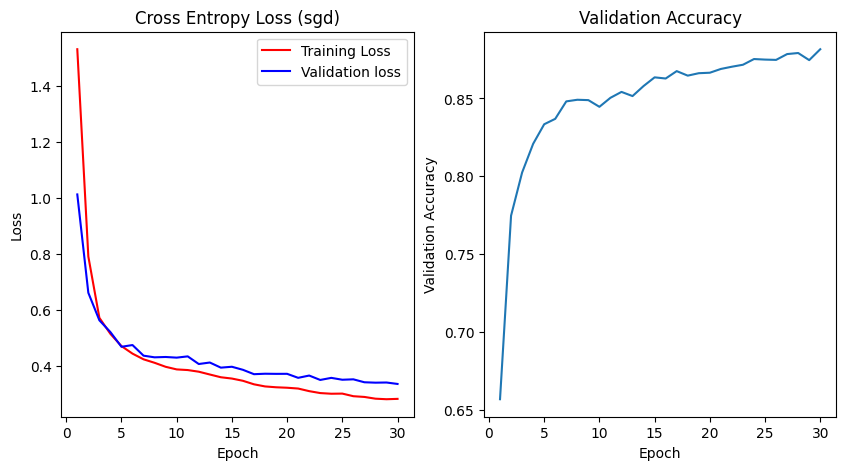

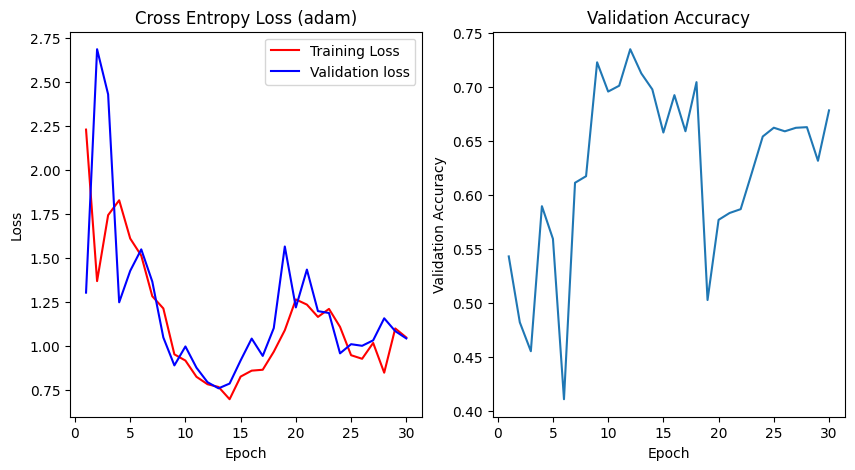

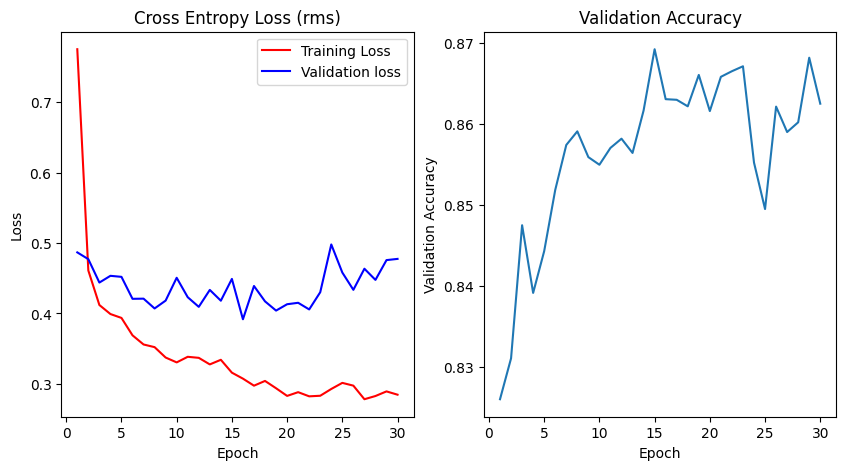

In [71]:
saved_states_sgd = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0, 'None', False, 'sgd', 0.001)
saved_states_adam = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0, 'None', False, 'adam', 0.001)
saved_states_rms = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0, 'None', False, 'rms', 0.001)

# **Dropout Comparison**

  3%|▎         | 1/30 [00:11<05:36, 11.59s/it]

Epoch: 0
Validation Accuracy:81.7998468875885%
Training Loss:0.7702982285112705
Validation Loss:0.5152695427338282


  7%|▋         | 2/30 [00:22<05:16, 11.31s/it]

Epoch: 1
Validation Accuracy:83.15500617027283%
Training Loss:0.5414867592307756
Validation Loss:0.4705470974246661


 10%|█         | 3/30 [00:34<05:05, 11.32s/it]

Epoch: 2
Validation Accuracy:83.67088437080383%
Training Loss:0.5151751345058657
Validation Loss:0.46324024349451065


 13%|█▎        | 4/30 [00:45<04:51, 11.23s/it]

Epoch: 3
Validation Accuracy:84.77553725242615%
Training Loss:0.48088910051111905
Validation Loss:0.43594938268264133


 17%|█▋        | 5/30 [00:56<04:37, 11.12s/it]

Epoch: 4
Validation Accuracy:85.17040610313416%
Training Loss:0.4767009222282554
Validation Loss:0.4293799599011739


 20%|██        | 6/30 [01:07<04:28, 11.20s/it]

Epoch: 5
Validation Accuracy:84.63046550750732%
Training Loss:0.4547872026011629
Validation Loss:0.42421649396419525


 23%|██▎       | 7/30 [01:18<04:17, 11.22s/it]

Epoch: 6
Validation Accuracy:84.78897213935852%
Training Loss:0.44436717933078984
Validation Loss:0.41360492010911304


 27%|██▋       | 8/30 [01:29<04:06, 11.19s/it]

Epoch: 7
Validation Accuracy:85.27938723564148%
Training Loss:0.4472692861871899
Validation Loss:0.42033422489960987


 30%|███       | 9/30 [01:41<03:56, 11.24s/it]

Epoch: 8
Validation Accuracy:85.60277819633484%
Training Loss:0.42749144221251867
Validation Loss:0.41395491113265354


 33%|███▎      | 10/30 [01:51<03:41, 11.10s/it]

Epoch: 9
Validation Accuracy:85.96863746643066%
Training Loss:0.4251880128428621
Validation Loss:0.39629651854435605


 37%|███▋      | 11/30 [02:03<03:31, 11.11s/it]

Epoch: 10
Validation Accuracy:84.84983444213867%
Training Loss:0.4226245880126953
Validation Loss:0.41499128689368564


 40%|████      | 12/30 [02:14<03:21, 11.22s/it]

Epoch: 11
Validation Accuracy:84.909987449646%
Training Loss:0.4282936619700126
Validation Loss:0.43414945155382156


 43%|████▎     | 13/30 [02:25<03:10, 11.19s/it]

Epoch: 12
Validation Accuracy:85.71670651435852%
Training Loss:0.4171214157117988
Validation Loss:0.41173243522644043


 47%|████▋     | 14/30 [02:36<02:58, 11.19s/it]

Epoch: 13
Validation Accuracy:86.02595329284668%
Training Loss:0.4208927888352916
Validation Loss:0.41672851890325546


 50%|█████     | 15/30 [02:47<02:46, 11.10s/it]

Epoch: 14
Validation Accuracy:86.41162514686584%
Training Loss:0.42136015194766924
Validation Loss:0.40909818063179654


 53%|█████▎    | 16/30 [02:59<02:36, 11.16s/it]

Epoch: 15
Validation Accuracy:85.40887832641602%
Training Loss:0.40852195755490717
Validation Loss:0.41828919450442


 57%|█████▋    | 17/30 [03:10<02:25, 11.17s/it]

Epoch: 16
Validation Accuracy:86.21490001678467%
Training Loss:0.40409318203071376
Validation Loss:0.40199809273084003


 60%|██████    | 18/30 [03:21<02:15, 11.26s/it]

Epoch: 17
Validation Accuracy:85.50229072570801%
Training Loss:0.39786682404437157
Validation Loss:0.42906281103690463


 63%|██████▎   | 19/30 [03:33<02:04, 11.35s/it]

Epoch: 18
Validation Accuracy:86.02595329284668%
Training Loss:0.40096017015430163
Validation Loss:0.4009641036391258


 67%|██████▋   | 20/30 [03:44<01:52, 11.30s/it]

Epoch: 19
Validation Accuracy:85.33740639686584%
Training Loss:0.39897848974983646
Validation Loss:0.41447639216979343


 70%|███████   | 21/30 [03:55<01:41, 11.30s/it]

Epoch: 20
Validation Accuracy:86.38402819633484%
Training Loss:0.39435446037436434
Validation Loss:0.4042284960548083


 73%|███████▎  | 22/30 [04:06<01:30, 11.26s/it]

Epoch: 21
Validation Accuracy:87.07682490348816%
Training Loss:0.38740177902410616
Validation Loss:0.4078502630194028


 77%|███████▋  | 23/30 [04:17<01:18, 11.16s/it]

Epoch: 22
Validation Accuracy:87.50920295715332%
Training Loss:0.3779848923660674
Validation Loss:0.3859473144014676


 80%|████████  | 24/30 [04:29<01:07, 11.17s/it]

Epoch: 23
Validation Accuracy:86.86240315437317%
Training Loss:0.37290313474412234
Validation Loss:0.3984016602238019


 83%|████████▎ | 25/30 [04:40<00:55, 11.19s/it]

Epoch: 24
Validation Accuracy:86.3429844379425%
Training Loss:0.3814308523850621
Validation Loss:0.4171175956726074


 87%|████████▋ | 26/30 [04:51<00:44, 11.18s/it]

Epoch: 25
Validation Accuracy:87.13201880455017%
Training Loss:0.3899498371020803
Validation Loss:0.38334863384564716


 90%|█████████ | 27/30 [05:02<00:33, 11.19s/it]

Epoch: 26
Validation Accuracy:85.72025299072266%
Training Loss:0.3821329727487744
Validation Loss:0.4062177613377571


 93%|█████████▎| 28/30 [05:14<00:22, 11.38s/it]

Epoch: 27
Validation Accuracy:86.0457718372345%
Training Loss:0.39036254641020074
Validation Loss:0.4117562373479207


 97%|█████████▋| 29/30 [05:25<00:11, 11.28s/it]

Epoch: 28
Validation Accuracy:86.54537200927734%
Training Loss:0.38743584026705546
Validation Loss:0.4193302517135938


100%|██████████| 30/30 [05:36<00:00, 11.22s/it]

Epoch: 29
Validation Accuracy:87.13980317115784%
Training Loss:0.3764997959699271
Validation Loss:0.3972358579436938


Test Accuracy:85.6738269329071%


  3%|▎         | 1/30 [00:10<05:12, 10.77s/it]

Epoch: 0
Validation Accuracy:77.35790610313416%
Training Loss:0.7833659052848816
Validation Loss:0.5585249414046606


  7%|▋         | 2/30 [00:22<05:10, 11.10s/it]

Epoch: 1
Validation Accuracy:80.90537190437317%
Training Loss:0.6198600488451292
Validation Loss:0.5267518510421118


 10%|█         | 3/30 [00:33<05:00, 11.12s/it]

Epoch: 2
Validation Accuracy:83.35809707641602%
Training Loss:0.5768223790065298
Validation Loss:0.47528379162152606


 13%|█▎        | 4/30 [00:44<04:49, 11.12s/it]

Epoch: 3
Validation Accuracy:82.56056904792786%
Training Loss:0.5442241601786524
Validation Loss:0.4888264959057172


 17%|█▋        | 5/30 [00:55<04:37, 11.11s/it]

Epoch: 4
Validation Accuracy:84.45920944213867%
Training Loss:0.5276005821970274
Validation Loss:0.4506904607017835


 20%|██        | 6/30 [01:06<04:23, 10.96s/it]

Epoch: 5
Validation Accuracy:84.89229679107666%
Training Loss:0.5114184221569097
Validation Loss:0.4331102992097537


 23%|██▎       | 7/30 [01:17<04:13, 11.04s/it]

Epoch: 6
Validation Accuracy:84.50379371643066%
Training Loss:0.5044876455136065
Validation Loss:0.43550291905800503


 27%|██▋       | 8/30 [01:28<04:03, 11.08s/it]

Epoch: 7
Validation Accuracy:84.93971228599548%
Training Loss:0.49589824845206065
Validation Loss:0.43642344574133557


 30%|███       | 9/30 [01:39<03:51, 11.01s/it]

Epoch: 8
Validation Accuracy:83.72678756713867%
Training Loss:0.4884533184879231
Validation Loss:0.4669405519962311


 33%|███▎      | 10/30 [01:50<03:39, 11.00s/it]

Epoch: 9
Validation Accuracy:85.28645634651184%
Training Loss:0.5025144143486923
Validation Loss:0.43067074070374173


 37%|███▋      | 11/30 [02:01<03:28, 10.99s/it]

Epoch: 10
Validation Accuracy:84.82577800750732%
Training Loss:0.49605382838339174
Validation Loss:0.43380877872308093


 40%|████      | 12/30 [02:12<03:17, 10.95s/it]

Epoch: 11
Validation Accuracy:85.47964692115784%
Training Loss:0.478684996658901
Validation Loss:0.4220615004499753


 43%|████▎     | 13/30 [02:23<03:06, 10.95s/it]

Epoch: 12
Validation Accuracy:84.34315323829651%
Training Loss:0.4771402340452626
Validation Loss:0.43323201437791187


 47%|████▋     | 14/30 [02:34<02:55, 10.94s/it]

Epoch: 13
Validation Accuracy:85.02533435821533%
Training Loss:0.4616698122249459
Validation Loss:0.4195965776840846


 50%|█████     | 15/30 [02:44<02:43, 10.91s/it]

Epoch: 14
Validation Accuracy:85.22135615348816%
Training Loss:0.4540741336795519
Validation Loss:0.4210718671480815


 53%|█████▎    | 16/30 [02:55<02:32, 10.92s/it]

Epoch: 15
Validation Accuracy:85.84904670715332%
Training Loss:0.45511002866727
Validation Loss:0.41460520525773364


 57%|█████▋    | 17/30 [03:06<02:21, 10.91s/it]

Epoch: 16
Validation Accuracy:85.13502478599548%
Training Loss:0.46755861617484185
Validation Loss:0.4246990183989207


 60%|██████    | 18/30 [03:18<02:12, 11.07s/it]

Epoch: 17
Validation Accuracy:85.05010604858398%
Training Loss:0.46474221629916496
Validation Loss:0.428190511961778


 63%|██████▎   | 19/30 [03:28<02:00, 10.96s/it]

Epoch: 18
Validation Accuracy:84.31909680366516%
Training Loss:0.46146085408498655
Validation Loss:0.4350647032260895


 67%|██████▋   | 20/30 [03:39<01:49, 10.95s/it]

Epoch: 19
Validation Accuracy:85.73015332221985%
Training Loss:0.4626426916077452
Validation Loss:0.4157010614871979


 70%|███████   | 21/30 [03:50<01:38, 10.99s/it]

Epoch: 20
Validation Accuracy:84.96801257133484%
Training Loss:0.448578879518329
Validation Loss:0.40218961735566455


 73%|███████▎  | 22/30 [04:02<01:28, 11.11s/it]

Epoch: 21
Validation Accuracy:86.10379695892334%
Training Loss:0.444766639819685
Validation Loss:0.4144771620631218


 77%|███████▋  | 23/30 [04:12<01:16, 10.98s/it]

Epoch: 22
Validation Accuracy:86.22481226921082%
Training Loss:0.4524897446609893
Validation Loss:0.3983582655588786


 80%|████████  | 24/30 [04:24<01:06, 11.16s/it]

Epoch: 23
Validation Accuracy:86.06275916099548%
Training Loss:0.43848795935792745
Validation Loss:0.3996773734688759


 83%|████████▎ | 25/30 [04:35<00:55, 11.14s/it]

Epoch: 24
Validation Accuracy:85.398268699646%
Training Loss:0.4399158378254692
Validation Loss:0.42985086143016815


 87%|████████▋ | 26/30 [04:47<00:45, 11.26s/it]

Epoch: 25
Validation Accuracy:86.2665593624115%
Training Loss:0.4407897316059976
Validation Loss:0.41204993426799774


 90%|█████████ | 27/30 [04:58<00:33, 11.25s/it]

Epoch: 26
Validation Accuracy:85.62896251678467%
Training Loss:0.4403605820997706
Validation Loss:0.40204016615947086


 93%|█████████▎| 28/30 [05:09<00:22, 11.20s/it]

Epoch: 27
Validation Accuracy:84.71326231956482%
Training Loss:0.4486041021234584
Validation Loss:0.4344632849097252


 97%|█████████▋| 29/30 [05:21<00:11, 11.43s/it]

Epoch: 28
Validation Accuracy:85.88584065437317%
Training Loss:0.4480197750172525
Validation Loss:0.41579610606034595


100%|██████████| 30/30 [05:33<00:00, 11.10s/it]

Epoch: 29
Validation Accuracy:85.84763407707214%
Training Loss:0.45023522708775865
Validation Loss:0.40426333248615265


Test Accuracy:85.36132574081421%


  3%|▎         | 1/30 [00:11<05:23, 11.14s/it]

Epoch: 0
Validation Accuracy:82.36809372901917%
Training Loss:0.8296166489709098
Validation Loss:0.5264380797743797


  7%|▋         | 2/30 [00:22<05:11, 11.11s/it]

Epoch: 1
Validation Accuracy:82.66672492027283%
Training Loss:0.6528325187710097
Validation Loss:0.4860904465119044


 10%|█         | 3/30 [00:33<05:06, 11.36s/it]

Epoch: 2
Validation Accuracy:82.51174092292786%
Training Loss:0.6162668072952414
Validation Loss:0.4883562798301379


 13%|█▎        | 4/30 [00:45<04:53, 11.30s/it]

Epoch: 3
Validation Accuracy:82.1140468120575%
Training Loss:0.5921349328643871
Validation Loss:0.49512114624182385


 17%|█▋        | 5/30 [00:55<04:38, 11.13s/it]

Epoch: 4
Validation Accuracy:84.63258743286133%
Training Loss:0.5843899671761494
Validation Loss:0.4489019190271695


 20%|██        | 6/30 [01:07<04:29, 11.23s/it]

Epoch: 5
Validation Accuracy:83.42674374580383%
Training Loss:0.56523397705465
Validation Loss:0.45527009665966034


 23%|██▎       | 7/30 [01:18<04:19, 11.28s/it]

Epoch: 6
Validation Accuracy:83.46778750419617%
Training Loss:0.5628951681110094
Validation Loss:0.47392963121334714


 27%|██▋       | 8/30 [01:29<04:06, 11.21s/it]

Epoch: 7
Validation Accuracy:84.01904702186584%
Training Loss:0.5547134727239609
Validation Loss:0.4565252438187599


 30%|███       | 9/30 [01:40<03:53, 11.10s/it]

Epoch: 8
Validation Accuracy:84.73731875419617%
Training Loss:0.535672906153607
Validation Loss:0.4333203633626302


 33%|███▎      | 10/30 [01:52<03:44, 11.21s/it]

Epoch: 9
Validation Accuracy:84.06646251678467%
Training Loss:0.5350937891118931
Validation Loss:0.4324293906490008


 37%|███▋      | 11/30 [02:03<03:35, 11.35s/it]

Epoch: 10
Validation Accuracy:84.85479354858398%
Training Loss:0.5428241347929217
Validation Loss:0.4403451730807622


 40%|████      | 12/30 [02:14<03:21, 11.17s/it]

Epoch: 11
Validation Accuracy:83.53076577186584%
Training Loss:0.5374910797712937
Validation Loss:0.4397101551294327


 43%|████▎     | 13/30 [02:25<03:07, 11.03s/it]

Epoch: 12
Validation Accuracy:84.09618735313416%
Training Loss:0.5322577874615507
Validation Loss:0.4497469837466876


 47%|████▋     | 14/30 [02:36<02:58, 11.17s/it]

Epoch: 13
Validation Accuracy:83.91502499580383%
Training Loss:0.514200007296958
Validation Loss:0.44454887757698697


 50%|█████     | 15/30 [02:47<02:46, 11.10s/it]

Epoch: 14
Validation Accuracy:84.90219712257385%
Training Loss:0.5254246167979151
Validation Loss:0.4277142435312271


 53%|█████▎    | 16/30 [02:58<02:35, 11.12s/it]

Epoch: 15
Validation Accuracy:85.41737198829651%
Training Loss:0.5255935523869857
Validation Loss:0.4139240011572838


 57%|█████▋    | 17/30 [03:10<02:25, 11.18s/it]

Epoch: 16
Validation Accuracy:84.95952486991882%
Training Loss:0.5122773939708494
Validation Loss:0.42655616998672485


 60%|██████    | 18/30 [03:21<02:14, 11.24s/it]

Epoch: 17
Validation Accuracy:83.87751579284668%
Training Loss:0.5206329099974543
Validation Loss:0.43292441219091415


 63%|██████▎   | 19/30 [03:32<02:02, 11.15s/it]

Epoch: 18
Validation Accuracy:85.06566882133484%
Training Loss:0.5106687104364611
Validation Loss:0.4213403711716334


 67%|██████▋   | 20/30 [03:43<01:50, 11.07s/it]

Epoch: 19
Validation Accuracy:86.36067509651184%
Training Loss:0.49800086639962104
Validation Loss:0.40858986725409824


 70%|███████   | 21/30 [03:54<01:39, 11.08s/it]

Epoch: 20
Validation Accuracy:85.69619059562683%
Training Loss:0.4981494371621114
Validation Loss:0.4234787697593371


 73%|███████▎  | 22/30 [04:05<01:29, 11.14s/it]

Epoch: 21
Validation Accuracy:84.92059707641602%
Training Loss:0.5041943676066849
Validation Loss:0.41707970947027206


 77%|███████▋  | 23/30 [04:16<01:16, 10.95s/it]

Epoch: 22
Validation Accuracy:85.50937175750732%
Training Loss:0.5070428187554737
Validation Loss:0.41715522358814877


 80%|████████  | 24/30 [04:27<01:05, 10.94s/it]

Epoch: 23
Validation Accuracy:86.04860305786133%
Training Loss:0.49053057803297945
Validation Loss:0.4190012315909068


 83%|████████▎ | 25/30 [04:38<00:55, 11.06s/it]

Epoch: 24
Validation Accuracy:85.3154718875885%
Training Loss:0.5034347660136673
Validation Loss:0.42685145139694214


 87%|████████▋ | 26/30 [04:49<00:44, 11.09s/it]

Epoch: 25
Validation Accuracy:85.18526554107666%
Training Loss:0.4933386563130145
Validation Loss:0.4457884356379509


 90%|█████████ | 27/30 [05:00<00:33, 11.14s/it]

Epoch: 26
Validation Accuracy:85.33387184143066%
Training Loss:0.49603158685396304
Validation Loss:0.4254635274410248


 93%|█████████▎| 28/30 [05:12<00:22, 11.18s/it]

Epoch: 27
Validation Accuracy:85.15059351921082%
Training Loss:0.5031676053438546
Validation Loss:0.43228699018557865


 97%|█████████▋| 29/30 [05:23<00:11, 11.13s/it]

Epoch: 28
Validation Accuracy:85.70256233215332%
Training Loss:0.49642654297486793
Validation Loss:0.41957032432158786


100%|██████████| 30/30 [05:34<00:00, 11.16s/it]

Epoch: 29
Validation Accuracy:85.79384684562683%
Training Loss:0.5064489341007089
Validation Loss:0.4289075161019961


Test Accuracy:84.48241949081421%


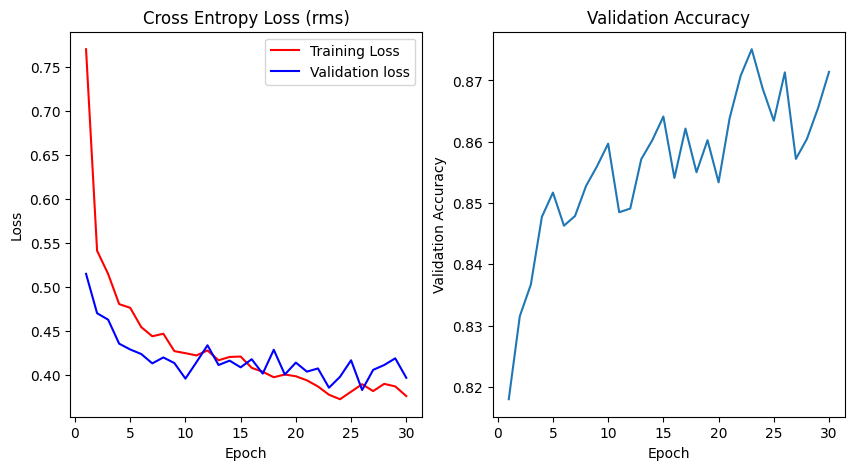

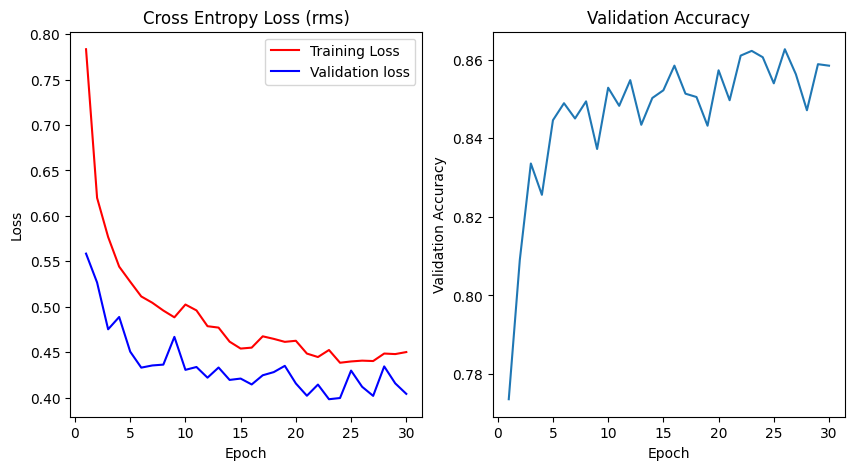

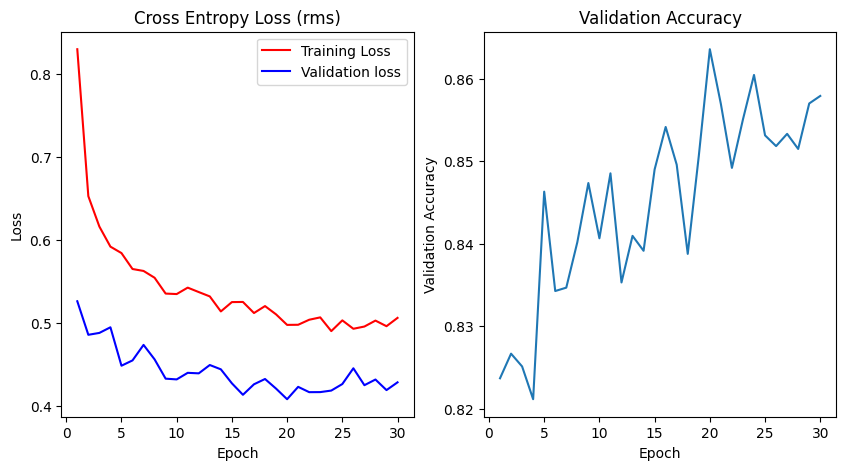

In [77]:
saved_states_rms_dropout_15 = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0.15, 'None', False, 'rms', 0.001)
saved_states_rms_dropout_25 = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0.25, 'None', False, 'rms', 0.001)
saved_states_rms_dropout_33 = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0.33, 'None', False, 'rms', 0.001)

In [79]:
print(saved_states_rms_dropout_15)
print(saved_states_rms_dropout_25)
print(saved_states_rms_dropout_33)

{'train_loss': 0.37290313474412234, 'val_loss': 0.38334863384564716, 'val_acc': tensor(0.8751)}
{'train_loss': 0.43848795935792745, 'val_loss': 0.3983582655588786, 'val_acc': tensor(0.8627)}
{'train_loss': 0.49053057803297945, 'val_loss': 0.40858986725409824, 'val_acc': tensor(0.8636)}


# **Weight Initialization Comparison**

  3%|▎         | 1/30 [00:10<05:09, 10.66s/it]

Epoch: 0
Validation Accuracy:80.20408749580383%
Training Loss:0.773580826116058
Validation Loss:0.5660445938507715


  7%|▋         | 2/30 [00:21<05:01, 10.78s/it]

Epoch: 1
Validation Accuracy:83.02409052848816%
Training Loss:0.49059641305005774
Validation Loss:0.46921451141436893


 10%|█         | 3/30 [00:32<04:51, 10.78s/it]

Epoch: 2
Validation Accuracy:84.41462516784668%
Training Loss:0.42594561290066196
Validation Loss:0.4475048507253329


 13%|█▎        | 4/30 [00:43<04:43, 10.90s/it]

Epoch: 3
Validation Accuracy:83.44655632972717%
Training Loss:0.40136515700592185
Validation Loss:0.4641333371400833


 17%|█▋        | 5/30 [00:54<04:34, 10.99s/it]

Epoch: 4
Validation Accuracy:84.4875156879425%
Training Loss:0.39476779047048316
Validation Loss:0.42478838562965393


 20%|██        | 6/30 [01:05<04:24, 11.01s/it]

Epoch: 5
Validation Accuracy:86.21206879615784%
Training Loss:0.37201149452407406
Validation Loss:0.38882868488629657


 23%|██▎       | 7/30 [01:17<04:18, 11.24s/it]

Epoch: 6
Validation Accuracy:85.85329055786133%
Training Loss:0.3537695405055892
Validation Loss:0.402995561559995


 27%|██▋       | 8/30 [01:28<04:05, 11.14s/it]

Epoch: 7
Validation Accuracy:85.35721898078918%
Training Loss:0.3498134857641076
Validation Loss:0.4279489542047183


 30%|███       | 9/30 [01:39<03:52, 11.06s/it]

Epoch: 8
Validation Accuracy:83.73599052429199%
Training Loss:0.3636207813924214
Validation Loss:0.45732880632082623


 33%|███▎      | 10/30 [01:49<03:39, 10.99s/it]

Epoch: 9
Validation Accuracy:86.29345297813416%
Training Loss:0.34878310603353213
Validation Loss:0.3941892584164937


 37%|███▋      | 11/30 [02:01<03:30, 11.06s/it]

Epoch: 10
Validation Accuracy:86.00330948829651%
Training Loss:0.32827123943364844
Validation Loss:0.39216595391432446


 40%|████      | 12/30 [02:12<03:19, 11.10s/it]

Epoch: 11
Validation Accuracy:86.30619049072266%
Training Loss:0.3284956711643147
Validation Loss:0.3798790400226911


 43%|████▎     | 13/30 [02:23<03:07, 11.05s/it]

Epoch: 12
Validation Accuracy:86.48593425750732%
Training Loss:0.3141268685741245
Validation Loss:0.4092877854903539


 47%|████▋     | 14/30 [02:34<02:57, 11.08s/it]

Epoch: 13
Validation Accuracy:86.69326901435852%
Training Loss:0.31400049534046426
Validation Loss:0.38870246708393097


 50%|█████     | 15/30 [02:45<02:44, 10.98s/it]

Epoch: 14
Validation Accuracy:87.04073429107666%
Training Loss:0.30447269343542605
Validation Loss:0.3919106150666873


 53%|█████▎    | 16/30 [02:55<02:31, 10.80s/it]

Epoch: 15
Validation Accuracy:86.65576577186584%
Training Loss:0.30728758014035673
Validation Loss:0.3941185201207797


 57%|█████▋    | 17/30 [03:06<02:21, 10.88s/it]

Epoch: 16
Validation Accuracy:86.54041886329651%
Training Loss:0.30087082692474687
Validation Loss:0.3945278525352478


 60%|██████    | 18/30 [03:17<02:11, 10.96s/it]

Epoch: 17
Validation Accuracy:86.47602200508118%
Training Loss:0.29753165087609923
Validation Loss:0.424067643781503


 63%|██████▎   | 19/30 [03:29<02:02, 11.15s/it]

Epoch: 18
Validation Accuracy:87.02375292778015%
Training Loss:0.29469004976299573
Validation Loss:0.388290969034036


 67%|██████▋   | 20/30 [03:40<01:51, 11.13s/it]

Epoch: 19
Validation Accuracy:85.72803139686584%
Training Loss:0.2835772792404553
Validation Loss:0.42998890827099484


 70%|███████   | 21/30 [03:51<01:38, 10.95s/it]

Epoch: 20
Validation Accuracy:86.64090633392334%
Training Loss:0.29538417495084257
Validation Loss:0.4035528252522151


 73%|███████▎  | 22/30 [04:02<01:27, 10.98s/it]

Epoch: 21
Validation Accuracy:86.7803156375885%
Training Loss:0.2763978677257052
Validation Loss:0.4435038094719251


 77%|███████▋  | 23/30 [04:12<01:16, 10.90s/it]

Epoch: 22
Validation Accuracy:87.01737523078918%
Training Loss:0.27924643752147565
Validation Loss:0.4157777155439059


 80%|████████  | 24/30 [04:23<01:05, 10.84s/it]

Epoch: 23
Validation Accuracy:86.89495921134949%
Training Loss:0.2782836275280647
Validation Loss:0.4144299402832985


 83%|████████▎ | 25/30 [04:34<00:55, 11.02s/it]

Epoch: 24
Validation Accuracy:86.49088740348816%
Training Loss:0.2856032908806261
Validation Loss:0.43293219804763794


 87%|████████▋ | 26/30 [04:45<00:43, 11.00s/it]

Epoch: 25
Validation Accuracy:87.27567195892334%
Training Loss:0.28393068417625605
Validation Loss:0.40337402870257694


 90%|█████████ | 27/30 [04:57<00:33, 11.05s/it]

Epoch: 26
Validation Accuracy:87.01242804527283%
Training Loss:0.27603752348782884
Validation Loss:0.41806818544864655


 93%|█████████▎| 28/30 [05:07<00:21, 10.96s/it]

Epoch: 27
Validation Accuracy:86.64090633392334%
Training Loss:0.28109936317745243
Validation Loss:0.43310301502545673


 97%|█████████▋| 29/30 [05:18<00:10, 10.88s/it]

Epoch: 28
Validation Accuracy:87.35634684562683%
Training Loss:0.2678006514906883
Validation Loss:0.4241279885172844


100%|██████████| 30/30 [05:29<00:00, 10.98s/it]

Epoch: 29
Validation Accuracy:87.1221125125885%
Training Loss:0.2648796929784541
Validation Loss:0.42509883642196655


Test Accuracy:86.083984375%


  3%|▎         | 1/30 [00:10<05:11, 10.74s/it]

Epoch: 0
Validation Accuracy:72.79849052429199%
Training Loss:176.37699263950563
Validation Loss:56.41424687703451


  7%|▋         | 2/30 [00:21<04:59, 10.71s/it]

Epoch: 1
Validation Accuracy:72.82113432884216%
Training Loss:45.35520395242943
Validation Loss:35.26074250539144


 10%|█         | 3/30 [00:32<04:56, 10.98s/it]

Epoch: 2
Validation Accuracy:71.76036238670349%
Training Loss:27.06604290008545
Validation Loss:23.937310536702473


 13%|█▎        | 4/30 [00:44<04:50, 11.19s/it]

Epoch: 3
Validation Accuracy:73.20043444633484%
Training Loss:18.286282143502866
Validation Loss:17.968753576278687


 17%|█▋        | 5/30 [00:54<04:35, 11.00s/it]

Epoch: 4
Validation Accuracy:69.90984082221985%
Training Loss:12.615368870069396
Validation Loss:13.597020785013834


 20%|██        | 6/30 [01:06<04:25, 11.07s/it]

Epoch: 5
Validation Accuracy:74.01564717292786%
Training Loss:9.469551032444215
Validation Loss:11.445731123288473


 23%|██▎       | 7/30 [01:16<04:12, 10.99s/it]

Epoch: 6
Validation Accuracy:68.93327832221985%
Training Loss:7.723882787632492
Validation Loss:10.100882172584534


 27%|██▋       | 8/30 [01:28<04:05, 11.15s/it]

Epoch: 7
Validation Accuracy:70.99468111991882%
Training Loss:5.894210702968094
Validation Loss:7.111688733100891


 30%|███       | 9/30 [01:39<03:54, 11.17s/it]

Epoch: 8
Validation Accuracy:67.722487449646%
Training Loss:4.8775180735678045
Validation Loss:6.543331265449524


 33%|███▎      | 10/30 [01:50<03:41, 11.09s/it]

Epoch: 9
Validation Accuracy:66.0793125629425%
Training Loss:3.56245737030821
Validation Loss:4.814098497231801


 37%|███▋      | 11/30 [02:01<03:30, 11.08s/it]

Epoch: 10
Validation Accuracy:67.56821274757385%
Training Loss:2.8417051457009226
Validation Loss:4.0922819177309675


 40%|████      | 12/30 [02:12<03:20, 11.14s/it]

Epoch: 11
Validation Accuracy:58.52935314178467%
Training Loss:2.2237193280795835
Validation Loss:3.4560122589270272


 43%|████▎     | 13/30 [02:23<03:07, 11.06s/it]

Epoch: 12
Validation Accuracy:60.99340319633484%
Training Loss:1.7848081493152763
Validation Loss:2.8857096234957376


 47%|████▋     | 14/30 [02:34<02:56, 11.05s/it]

Epoch: 13
Validation Accuracy:64.56281542778015%
Training Loss:1.5587108258931142
Validation Loss:2.518421014149984


 50%|█████     | 15/30 [02:45<02:45, 11.00s/it]

Epoch: 14
Validation Accuracy:67.820143699646%
Training Loss:1.3621303202970974
Validation Loss:2.078259905179342


 53%|█████▎    | 16/30 [02:56<02:35, 11.09s/it]

Epoch: 15
Validation Accuracy:67.41748452186584%
Training Loss:1.1477963856931002
Validation Loss:2.309112081925074


 57%|█████▋    | 17/30 [03:08<02:24, 11.09s/it]

Epoch: 16
Validation Accuracy:65.03481864929199%
Training Loss:1.2280502190005105
Validation Loss:2.525228261947632


 60%|██████    | 18/30 [03:18<02:12, 11.01s/it]

Epoch: 17
Validation Accuracy:62.1454656124115%
Training Loss:1.169473185854138
Validation Loss:2.0855183601379395


 63%|██████▎   | 19/30 [03:30<02:01, 11.05s/it]

Epoch: 18
Validation Accuracy:61.765456199645996%
Training Loss:1.3559741816430722
Validation Loss:2.5464018980662027


 67%|██████▋   | 20/30 [03:41<01:50, 11.08s/it]

Epoch: 19
Validation Accuracy:65.14096260070801%
Training Loss:1.158027654548861
Validation Loss:2.2862118979295096


 70%|███████   | 21/30 [03:52<01:39, 11.05s/it]

Epoch: 20
Validation Accuracy:64.673912525177%
Training Loss:1.0671619036287632
Validation Loss:1.9781247129042943


 73%|███████▎  | 22/30 [04:03<01:28, 11.08s/it]

Epoch: 21
Validation Accuracy:68.77618432044983%
Training Loss:0.9402960235217832
Validation Loss:2.1136199633280435


 77%|███████▋  | 23/30 [04:14<01:18, 11.18s/it]

Epoch: 22
Validation Accuracy:62.729984521865845%
Training Loss:0.9694513982197024
Validation Loss:2.158653904994329


 80%|████████  | 24/30 [04:25<01:06, 11.14s/it]

Epoch: 23
Validation Accuracy:61.687612533569336%
Training Loss:1.0430762458522365
Validation Loss:2.073729654153188


 83%|████████▎ | 25/30 [04:36<00:55, 11.15s/it]

Epoch: 24
Validation Accuracy:63.644278049468994%
Training Loss:1.0038455381708324
Validation Loss:1.8571885426839192


 87%|████████▋ | 26/30 [04:48<00:44, 11.19s/it]

Epoch: 25
Validation Accuracy:66.17626547813416%
Training Loss:1.002270038960115
Validation Loss:1.7273957033952076


 90%|█████████ | 27/30 [04:59<00:33, 11.21s/it]

Epoch: 26
Validation Accuracy:67.09479689598083%
Training Loss:0.9373520815147544
Validation Loss:1.5727744102478027


 93%|█████████▎| 28/30 [05:10<00:22, 11.14s/it]

Epoch: 27
Validation Accuracy:64.357590675354%
Training Loss:0.9077498069349325
Validation Loss:1.6009840418895085


 97%|█████████▋| 29/30 [05:21<00:10, 11.00s/it]

Epoch: 28
Validation Accuracy:69.1300094127655%
Training Loss:0.8694036552366221
Validation Loss:1.6615270127852757


100%|██████████| 30/30 [05:31<00:00, 11.06s/it]

Epoch: 29
Validation Accuracy:69.46189999580383%
Training Loss:0.9071020950686257
Validation Loss:1.662910595536232


Test Accuracy:68.75976324081421%


  3%|▎         | 1/30 [00:11<05:22, 11.11s/it]

Epoch: 0
Validation Accuracy:80.6513249874115%
Training Loss:0.9267601770050121
Validation Loss:0.5989623914162318


  7%|▋         | 2/30 [00:22<05:09, 11.06s/it]

Epoch: 1
Validation Accuracy:82.44735598564148%
Training Loss:0.5292023673372449
Validation Loss:0.49287810921669006


 10%|█         | 3/30 [00:33<05:02, 11.22s/it]

Epoch: 2
Validation Accuracy:83.53784680366516%
Training Loss:0.46442331092537575
Validation Loss:0.4756993701060613


 13%|█▎        | 4/30 [00:44<04:46, 11.03s/it]

Epoch: 3
Validation Accuracy:84.63612198829651%
Training Loss:0.4213103694173525
Validation Loss:0.4436093245943387


 17%|█▋        | 5/30 [00:55<04:38, 11.14s/it]

Epoch: 4
Validation Accuracy:85.20578742027283%
Training Loss:0.4065218955840705
Validation Loss:0.45022132992744446


 20%|██        | 6/30 [01:06<04:25, 11.07s/it]

Epoch: 5
Validation Accuracy:83.85982513427734%
Training Loss:0.3918853185649188
Validation Loss:0.45434806992610294


 23%|██▎       | 7/30 [01:17<04:13, 11.03s/it]

Epoch: 6
Validation Accuracy:85.14068126678467%
Training Loss:0.3873483974416301
Validation Loss:0.4489007443189621


 27%|██▋       | 8/30 [01:28<04:01, 10.97s/it]

Epoch: 7
Validation Accuracy:84.861159324646%
Training Loss:0.37562291802100417
Validation Loss:0.4507451578974724


 30%|███       | 9/30 [01:39<03:51, 11.04s/it]

Epoch: 8
Validation Accuracy:85.86460947990417%
Training Loss:0.3727036807334648
Validation Loss:0.40853940198818844


 33%|███▎      | 10/30 [01:50<03:40, 11.02s/it]

Epoch: 9
Validation Accuracy:86.40313744544983%
Training Loss:0.3537579617410336
Validation Loss:0.41467757523059845


 37%|███▋      | 11/30 [02:01<03:29, 11.05s/it]

Epoch: 10
Validation Accuracy:85.87239384651184%
Training Loss:0.34288193960234803
Validation Loss:0.41958046952883404


 40%|████      | 12/30 [02:13<03:20, 11.16s/it]

Epoch: 11
Validation Accuracy:84.73802208900452%
Training Loss:0.3498025246948566
Validation Loss:0.44787661482890445


 43%|████▎     | 13/30 [02:24<03:10, 11.22s/it]

Epoch: 12
Validation Accuracy:85.90636253356934%
Training Loss:0.3458320546262669
Validation Loss:0.41736003508170444


 47%|████▋     | 14/30 [02:35<02:58, 11.15s/it]

Epoch: 13
Validation Accuracy:86.37129664421082%
Training Loss:0.33510423437604364
Validation Loss:0.4151305283109347


 50%|█████     | 15/30 [02:46<02:46, 11.08s/it]

Epoch: 14
Validation Accuracy:86.29274368286133%
Training Loss:0.3355555925166832
Validation Loss:0.4011858055988948


 53%|█████▎    | 16/30 [02:57<02:33, 10.97s/it]

Epoch: 15
Validation Accuracy:85.84620952606201%
Training Loss:0.33808776230182286
Validation Loss:0.4203564450144768


 57%|█████▋    | 17/30 [03:08<02:23, 11.01s/it]

Epoch: 16
Validation Accuracy:85.5617344379425%
Training Loss:0.33565139573700026
Validation Loss:0.4515034407377243


 60%|██████    | 18/30 [03:19<02:12, 11.01s/it]

Epoch: 17
Validation Accuracy:85.17677187919617%
Training Loss:0.3243723064661026
Validation Loss:0.41262628386418027


 63%|██████▎   | 19/30 [03:29<02:00, 10.93s/it]

Epoch: 18
Validation Accuracy:86.24957203865051%
Training Loss:0.3135934595791799
Validation Loss:0.42130380868911743


 67%|██████▋   | 20/30 [03:40<01:49, 10.97s/it]

Epoch: 19
Validation Accuracy:86.40171885490417%
Training Loss:0.31507867883961155
Validation Loss:0.40662628908952075


 70%|███████   | 21/30 [03:52<01:39, 11.05s/it]

Epoch: 20
Validation Accuracy:86.59207820892334%
Training Loss:0.31139796072582027
Validation Loss:0.42902760207653046


 73%|███████▎  | 22/30 [04:03<01:28, 11.07s/it]

Epoch: 21
Validation Accuracy:86.43710613250732%
Training Loss:0.315064567439961
Validation Loss:0.42075282086928684


 77%|███████▋  | 23/30 [04:14<01:17, 11.04s/it]

Epoch: 22
Validation Accuracy:86.40738129615784%
Training Loss:0.31650284171666737
Validation Loss:0.40239912271499634


 80%|████████  | 24/30 [04:25<01:06, 11.04s/it]

Epoch: 23
Validation Accuracy:85.49168109893799%
Training Loss:0.3194264411082808
Validation Loss:0.45894933740297955


 83%|████████▎ | 25/30 [04:36<00:54, 10.95s/it]

Epoch: 24
Validation Accuracy:86.73997521400452%
Training Loss:0.3092310466575173
Validation Loss:0.43634795397520065


 87%|████████▋ | 26/30 [04:46<00:43, 10.95s/it]

Epoch: 25
Validation Accuracy:86.84329986572266%
Training Loss:0.297305499888816
Validation Loss:0.4176827346285184


 90%|█████████ | 27/30 [04:57<00:32, 10.97s/it]

Epoch: 26
Validation Accuracy:85.63108444213867%
Training Loss:0.3011565039742668
Validation Loss:0.45932498822609585


 93%|█████████▎| 28/30 [05:09<00:22, 11.09s/it]

Epoch: 27
Validation Accuracy:86.95652484893799%
Training Loss:0.3001658608609775
Validation Loss:0.4184402674436569


 97%|█████████▋| 29/30 [05:20<00:11, 11.17s/it]

Epoch: 28
Validation Accuracy:86.69893741607666%
Training Loss:0.2946744220999052
Validation Loss:0.44384241104125977


100%|██████████| 30/30 [05:31<00:00, 11.06s/it]

Epoch: 29
Validation Accuracy:85.83489060401917%
Training Loss:0.28571159350422193
Validation Loss:0.4649608830610911


Test Accuracy:85.6249988079071%


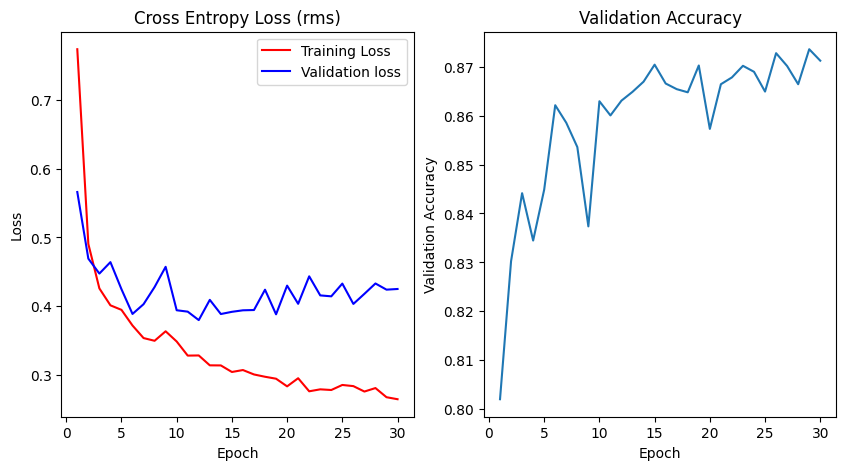

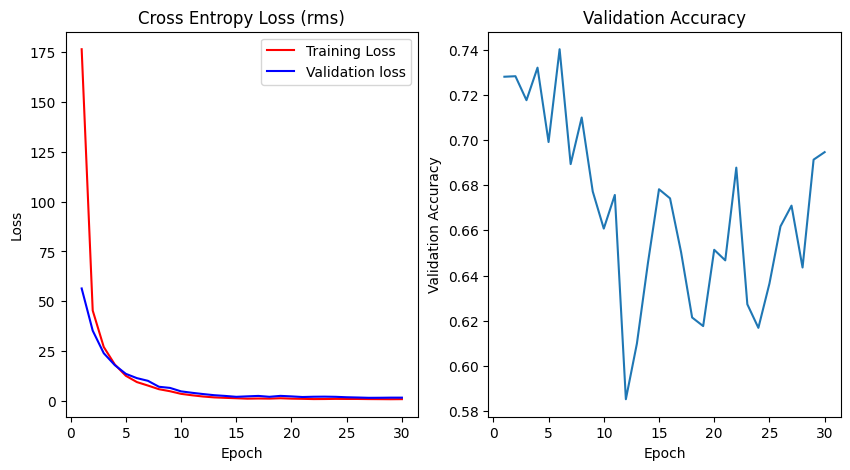

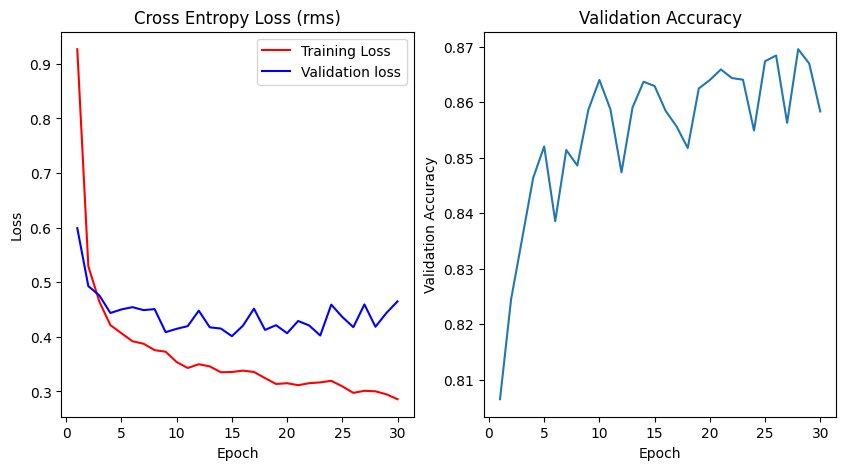

In [78]:
saved_states_weight_xavier = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0, 'xavier', False, 'rms', 0.001)
saved_states_weight_random = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0, 'random', False, 'rms', 0.001)
saved_states_weight_kaiming = parameter_tunning(neuron_dim_optimal, epochs, train_batches, val_batches, test_batches, 0, 'kaiming', False, 'rms', 0.001)

In [80]:
print(saved_states_weight_xavier)
print(saved_states_weight_random)
print(saved_states_weight_kaiming)

{'train_loss': 0.2648796929784541, 'val_loss': 0.3798790400226911, 'val_acc': tensor(0.8736)}
{'train_loss': 0.8694036552366221, 'val_loss': 1.5727744102478027, 'val_acc': tensor(0.7402)}
{'train_loss': 0.28571159350422193, 'val_loss': 0.4011858055988948, 'val_acc': tensor(0.8696)}


# **Batch Normalization**

In [ ]:
saved_states_base = parameter_tunning(neuron_dim_base, epochs, train_batches, val_batches, test_batches, 0, 'None', True, 'rms', lr_base)

  3%|▎         | 1/30 [00:10<05:11, 10.75s/it]

Epoch: 0
Validation Accuracy:83.84992480278015%
Training Loss:0.7269569348614171
Validation Loss:0.5250363325079282


  7%|▋         | 2/30 [00:22<05:13, 11.20s/it]

Epoch: 1
Validation Accuracy:84.8293125629425%
Training Loss:0.42733040592580473
Validation Loss:0.41959936171770096


 10%|█         | 3/30 [00:33<04:57, 11.01s/it]

Epoch: 2
Validation Accuracy:87.01100945472717%
Training Loss:0.36670796292008095
Validation Loss:0.3666493495305379


 13%|█▎        | 4/30 [00:44<04:45, 10.99s/it]

Epoch: 3
Validation Accuracy:87.0987594127655%
Training Loss:0.3390137698009329
Validation Loss:0.36528245359659195


 17%|█▋        | 5/30 [00:55<04:35, 11.03s/it]

Epoch: 4
Validation Accuracy:87.83259391784668%
Training Loss:0.3162595861644115
Validation Loss:0.3372461274266243


 20%|██        | 6/30 [01:05<04:23, 10.98s/it]

Epoch: 5
Validation Accuracy:87.86727786064148%
Training Loss:0.29998117277644715
Validation Loss:0.33646177003781


 23%|██▎       | 7/30 [01:17<04:13, 11.02s/it]

Epoch: 6
Validation Accuracy:87.15961575508118%
Training Loss:0.2860492954276643
Validation Loss:0.34537236640850705


 27%|██▋       | 8/30 [01:28<04:02, 11.02s/it]

Epoch: 7
Validation Accuracy:87.73069381713867%
Training Loss:0.27599495494703075
Validation Loss:0.3457593197623889


 30%|███       | 9/30 [01:39<03:56, 11.28s/it]

Epoch: 8
Validation Accuracy:88.15599083900452%
Training Loss:0.2605718781925597
Validation Loss:0.33506383498509723


 33%|███▎      | 10/30 [01:50<03:43, 11.16s/it]

Epoch: 9
Validation Accuracy:88.01658749580383%
Training Loss:0.2614937998213858
Validation Loss:0.3279826616247495


 37%|███▋      | 11/30 [02:02<03:33, 11.24s/it]

Epoch: 10
Validation Accuracy:87.95360922813416%
Training Loss:0.2515127993417236
Validation Loss:0.34650419155756634
